In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from IPython.display import clear_output

In [48]:
DATA_PATH = "./Emotion_classify_Data.csv"

PLOT_COLORS = ["red", "green", "blue"]

EMBEDDING_DIMENSIONS = 100

EPOCHS = 100
BATCH_SIZE = 32

In [49]:
def load_data() -> pd.DataFrame:
    return pd.read_csv(DATA_PATH)

def get_longest_sentence(doc_table: pd.Series) -> int:
    doc_list = doc_table.tolist()
    longest_sentence = 0

    for s in doc_list:
        sentence_len = len(s)
        if sentence_len > longest_sentence:
            longest_sentence = sentence_len
    
    return longest_sentence

def get_vocabulary(column_with_docs: str, dataframe: pd.DataFrame) -> set:
    documents: list[str] = dataframe[column_with_docs].to_list()
    documents_text: str = " ".join(documents)
    vocabulary: set = set(documents_text.split(" "))
    return vocabulary

def convert_word_to_index(vocabulary: set) -> dict:
    word2indx = {word: index for index, word in enumerate(vocabulary)}
    return word2indx

def create_features_table(unique_values: list) -> dict:
    features_table: dict = {}
    feature_code: int = 0
    for unique_value in unique_values:
        features_table[unique_value] = feature_code
        feature_code += 1
    return features_table

def encode_classes(feature_table: dict, dataframe: pd.DataFrame) -> pd.DataFrame:
    new_df: pd.DataFrame = dataframe.copy()
    
    for k, v in feature_table.items():
        new_df["Emotion"][new_df["Emotion"] == k] = v
    
    return new_df

def vectorize_sentence(word2indx: dict, sentence: str) -> list[int]:
    sentence = sentence.lower().split(" ")
    vector = [word2indx[word] for word in sentence]
    return vector

def convert_to_embedding(emb_layer: nn.Embedding, vector: list[int]) -> torch.LongTensor:
    return emb_layer(torch.LongTensor(vector))

def plot_emotions_distribution(loaded_dataframe: pd.DataFrame):
    emotions = loaded_dataframe["Emotion"].unique()
    emotions_count = []
    for emotion in emotions:
        emotion_doc_counter = len(loaded_dataframe[loaded_dataframe["Emotion"] == emotion])
        emotions_count.append(emotion_doc_counter)
    
    _, ax = plt.subplots()
    ax.bar(emotions, emotions_count, label=emotions, color=PLOT_COLORS)
    ax.set_title("Emotions distribution")
    plt.show()
    

In [50]:
emotion_data = load_data()

In [51]:
emotion_data.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [52]:
emotion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [53]:
emotion_data.isna().sum()

Comment    0
Emotion    0
dtype: int64

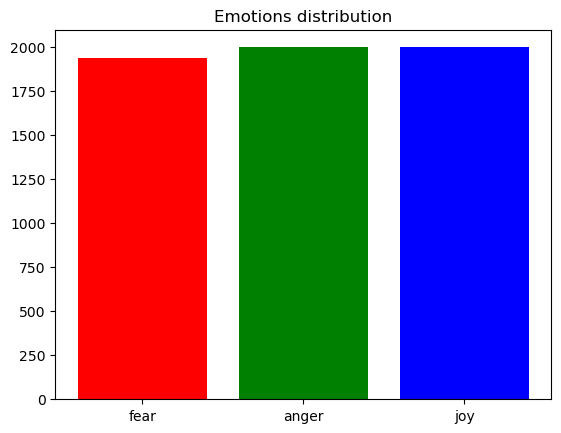

In [54]:
plot_emotions_distribution(emotion_data)

In [55]:
emotion_types = emotion_data["Emotion"].unique()
emotion_types_len = len(emotion_types)
emotion_types_encoding = create_features_table(emotion_types.tolist())
emotion_types, emotion_types_encoding

(array(['fear', 'anger', 'joy'], dtype=object),
 {'fear': 0, 'anger': 1, 'joy': 2})

In [56]:
vocabulary = get_vocabulary("Comment", emotion_data)

In [57]:
longest_sentence = get_longest_sentence(emotion_data["Comment"])
longest_sentence

298

In [58]:
vocabulary_size = len(vocabulary)
vocabulary, vocabulary_size

({'surprising',
  'youre',
  'unafraid',
  'each',
  'traumatic',
  'rupaul',
  'jaws',
  'creep',
  'marvellous',
  'shape',
  'languagedirection',
  'bicycle',
  'falling',
  'phoenix',
  'product',
  'rounds',
  'weighting',
  'lively',
  'mud',
  'rants',
  'king',
  'body',
  'sarah',
  'exhaling',
  'potatoes',
  'shine',
  'might',
  'windmill',
  'citizen',
  'chronically',
  'cuts',
  'resort',
  'hoards',
  'demotivated',
  'jacket',
  'bright',
  'dreamed',
  'sugar',
  'echo',
  'professors',
  'climb',
  'mg',
  'zipline',
  'study',
  'distressed',
  'memory',
  'plug',
  'trick',
  'if',
  'despised',
  'paul',
  'e',
  'follower',
  'becasue',
  'clicked',
  'lot',
  'lends',
  'santa',
  'timer',
  'forgot',
  'open',
  'weakness',
  'oblige',
  'unsatisfied',
  'acts',
  'overrrrrrrrrrrr',
  'oscars',
  'looses',
  'procedure',
  'january',
  'settled',
  'destructive',
  'interviews',
  'punjabi',
  'warmed',
  'productivity',
  'confidence',
  'rise',
  'taewuhbeory

In [59]:
word2indx = convert_word_to_index(vocabulary)

In [60]:
word2indx

{'surprising': 0,
 'youre': 1,
 'unafraid': 2,
 'each': 3,
 'traumatic': 4,
 'rupaul': 5,
 'jaws': 6,
 'creep': 7,
 'marvellous': 8,
 'shape': 9,
 'languagedirection': 10,
 'bicycle': 11,
 'falling': 12,
 'phoenix': 13,
 'product': 14,
 'rounds': 15,
 'weighting': 16,
 'lively': 17,
 'mud': 18,
 'rants': 19,
 'king': 20,
 'body': 21,
 'sarah': 22,
 'exhaling': 23,
 'potatoes': 24,
 'shine': 25,
 'might': 26,
 'windmill': 27,
 'citizen': 28,
 'chronically': 29,
 'cuts': 30,
 'resort': 31,
 'hoards': 32,
 'demotivated': 33,
 'jacket': 34,
 'bright': 35,
 'dreamed': 36,
 'sugar': 37,
 'echo': 38,
 'professors': 39,
 'climb': 40,
 'mg': 41,
 'zipline': 42,
 'study': 43,
 'distressed': 44,
 'memory': 45,
 'plug': 46,
 'trick': 47,
 'if': 48,
 'despised': 49,
 'paul': 50,
 'e': 51,
 'follower': 52,
 'becasue': 53,
 'clicked': 54,
 'lot': 55,
 'lends': 56,
 'santa': 57,
 'timer': 58,
 'forgot': 59,
 'open': 60,
 'weakness': 61,
 'oblige': 62,
 'unsatisfied': 63,
 'acts': 64,
 'overrrrrrrrrrrr

In [61]:
embedding_layer = nn.Embedding(vocabulary_size, EMBEDDING_DIMENSIONS)
test_sentence: str = np.random.choice(emotion_data["Comment"].to_list())
formatted_test_sentence: str = test_sentence.lower().split(" ")
sentence_w2indx: list[int] = [word2indx[word] for word in formatted_test_sentence]
sentence_vector = embedding_layer(torch.LongTensor(sentence_w2indx))
print(f"Test sentence: {formatted_test_sentence}\nVector:{sentence_vector}")

Test sentence: ['watched', 'a', 'horror', 'movie', 'which', 'involved', 'sexual', 'attacks', 'on', 'women']
Vector:tensor([[ 1.2473e+00,  2.2934e-02,  1.9771e-01,  7.1072e-01, -1.5060e+00,
          1.5954e+00, -1.4238e+00, -2.2511e+00,  2.6097e-01,  7.7440e-01,
          7.8787e-01,  7.4698e-01, -1.5802e+00, -9.9936e-03, -1.3080e+00,
         -3.2907e-01, -2.1198e-01, -2.1171e-01,  6.8849e-01,  1.2264e+00,
         -7.1645e-01, -8.6847e-01, -1.0590e-01, -3.2082e-01,  9.8653e-01,
          7.6080e-01, -1.9225e+00, -2.1989e+00, -7.3346e-01,  1.4742e-01,
          1.0677e+00,  1.1221e-01, -1.0114e+00, -1.3326e-01, -1.2177e+00,
         -2.3260e+00, -1.6554e+00, -1.4086e+00,  6.7286e-01,  1.3144e+00,
          4.4504e-01,  1.2063e+00, -8.4046e-01,  1.5856e+00, -1.2522e+00,
         -3.6433e-01, -2.7250e-01,  1.7549e+00,  5.8663e-01,  1.1544e-01,
          1.7628e+00,  1.3651e+00,  1.6226e+00, -9.5761e-01,  2.2988e+00,
          1.2984e+00,  7.2988e-01, -1.1658e+00,  1.5031e+00, -4.1515e-0

In [62]:
preprocessed_dataframe = encode_classes(emotion_types_encoding, emotion_data)
preprocessed_dataframe.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,0
1,im so full of life i feel appalled,1
2,i sit here to write i start to dig out my feel...,0
3,ive been really angry with r and i feel like a...,2
4,i feel suspicious if there is no one outside l...,0


In [63]:
X, y = preprocessed_dataframe["Comment"], preprocessed_dataframe["Emotion"]
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [64]:
X_train.head()

4771    im feeling selfish enough to start this lovely...
4883    i feel outraged that my life is so easy so ble...
1590    i have written but you feel the need to point ...
2765    i was still feelin kind of irritable and funky...
1195    is name in the opening passages saying it may ...
Name: Comment, dtype: object

In [65]:
Y_train.head()

4771    1
4883    1
1590    1
2765    1
1195    2
Name: Emotion, dtype: object

In [66]:
class DatasetLoader(Dataset):
    def __init__(self, X, y) -> None:
        super(DatasetLoader, self).__init__()
        self.X = np.array(X)
        self.y = np.array(y)
        print(self.y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        sentence = self.X[index]
        vector = vectorize_sentence(word2indx, sentence)

        while len(vector) != longest_sentence:
            vector.append(0)

        emb = convert_to_embedding(embedding_layer, vector)
        return emb, self.y[index]

In [67]:
train_set = DatasetLoader(X_train, Y_train)
test_set = DatasetLoader(X_test, Y_test)
train_iter = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_iter = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

[1 1 1 ... 1 0 2]
[0 2 0 ... 1 0 2]


In [68]:
x, y = next(iter(train_iter))
x.shape, y

(torch.Size([32, 298, 100]),
 tensor([1, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1,
         2, 1, 0, 1, 1, 2, 2, 0]))

In [75]:
class MultiClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=longest_sentence, out_channels=128, kernel_size=3),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(6272, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, emotion_types_len),
        )
        
    def forward(self, x: torch.TensorType):
        x = x.view(-1, x.size(1), x.size(2))

        return self.model(x)

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [77]:
model = MultiClassifier()
model.to(device)
model(x.to(device))

tensor([[-0.0290,  0.0340,  0.1213],
        [-0.0505,  0.0158,  0.1437],
        [-0.0496,  0.0259,  0.1315],
        [-0.0602,  0.0602,  0.1304],
        [-0.0788,  0.0082,  0.1325],
        [-0.0433,  0.0328,  0.1341],
        [-0.0485,  0.0397,  0.1258],
        [-0.0367,  0.0153,  0.1485],
        [-0.0568,  0.0346,  0.1428],
        [-0.0438,  0.0155,  0.1501],
        [-0.0419,  0.0279,  0.1549],
        [-0.0453,  0.0535,  0.1440],
        [-0.0420,  0.0262,  0.1297],
        [-0.0444,  0.0246,  0.1485],
        [-0.0494,  0.0193,  0.1537],
        [-0.0272,  0.0320,  0.1315],
        [-0.0325,  0.0399,  0.1275],
        [-0.0253,  0.0600,  0.1515],
        [-0.0495,  0.0274,  0.1555],
        [-0.0448,  0.0234,  0.1612],
        [-0.0492,  0.0529,  0.1524],
        [-0.0228,  0.0096,  0.1615],
        [-0.0502,  0.0264,  0.1583],
        [-0.0396,  0.0430,  0.1526],
        [-0.0523,  0.0188,  0.1444],
        [-0.0210,  0.0229,  0.1158],
        [-0.0613,  0.0558,  0.1194],
 

In [78]:
model_optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [79]:
model(x.to(device))

tensor([[-0.0290,  0.0340,  0.1213],
        [-0.0505,  0.0158,  0.1437],
        [-0.0496,  0.0259,  0.1315],
        [-0.0602,  0.0602,  0.1304],
        [-0.0788,  0.0082,  0.1325],
        [-0.0433,  0.0328,  0.1341],
        [-0.0485,  0.0397,  0.1258],
        [-0.0367,  0.0153,  0.1485],
        [-0.0568,  0.0346,  0.1428],
        [-0.0438,  0.0155,  0.1501],
        [-0.0419,  0.0279,  0.1549],
        [-0.0453,  0.0535,  0.1440],
        [-0.0420,  0.0262,  0.1297],
        [-0.0444,  0.0246,  0.1485],
        [-0.0494,  0.0193,  0.1537],
        [-0.0272,  0.0320,  0.1315],
        [-0.0325,  0.0399,  0.1275],
        [-0.0253,  0.0600,  0.1515],
        [-0.0495,  0.0274,  0.1555],
        [-0.0448,  0.0234,  0.1612],
        [-0.0492,  0.0529,  0.1524],
        [-0.0228,  0.0096,  0.1615],
        [-0.0502,  0.0264,  0.1583],
        [-0.0396,  0.0430,  0.1526],
        [-0.0523,  0.0188,  0.1444],
        [-0.0210,  0.0229,  0.1158],
        [-0.0613,  0.0558,  0.1194],
 

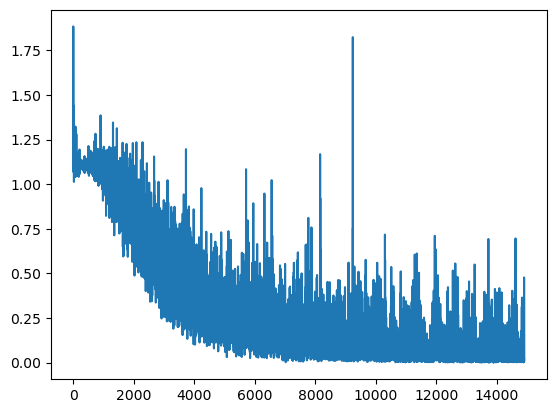

Epoch [100/99], 0.0106893889605999


In [80]:
training_losses = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    model.train()
    
    for input, labels in tqdm(train_iter):
        labels = labels.to(device, dtype=torch.long)
        model_optimizer.zero_grad()
        outputs = model(input.to(device))
        loss = criterion(outputs, labels)
        loss.backward()
        
        training_losses.append(loss.item())
        

        model_optimizer.step()
    
    clear_output(wait=True)
    plt.plot(training_losses)
    plt.show()
    print(f'Epoch [{epoch+1}/{epoch}], {loss.item()}')

In [81]:
torch.save(model.state_dict(), "./model.h5")

In [91]:
total_correct = 0
total = 0

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for inp, labels in test_iter:
        inp = inp.to(device)
        labels = labels.to(device)
        
        outputs = model(inp)
        _, indx = torch.max(outputs, dim=1)
        
        total += len(labels)
        total_correct += torch.sum(indx == labels).item()

# Calculate the overall accuracy
accuracy = total_correct / total
print(f"Model accuracy: {accuracy * 100:.2f}%")


Model accuracy: 44.78%
